# Image-Based Experiment: Curse of Knowledge Analysis

This notebook analyzes whether language models exhibit the "curse of knowledge" bias in false-belief reasoning, comparing their performance to human data from Birch & Bloom (2007).

## Background

**The Curse of Knowledge**: A cognitive bias where one's own knowledge of an outcome compromises the ability to reason about another person's beliefs about that outcome.

**Experimental Design**:
- 3 conditions: Ignorance, Knowledge-Plausible, Knowledge-Implausible
- 5 models: GPT-4o-mini, GPT-4o, GPT-5-low, GPT-5-medium, GPT-5-high
- Comparison with human baseline (Birch & Bloom 2007)

In [1]:
import pandas as pd
import numpy as np
import json
import re
from scipy import stats
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


## Step 1: Load and Parse Data

In [2]:
# Load data
df = pd.read_csv("model_responses_image.csv")
print(f"Loaded {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")
df.head()

Loaded 450 rows
Columns: ['names', 'colors', 'condition', 'model', 'instrument', 'trial', 'stimulus', 'result', 'reasoning']


,names,colors,condition,model,instrument,trial,stimulus,result,reasoning
0,"('Vicki', 'Denise')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,violin,0,"[IMAGE STIMULUS] names=('Vicki', 'Denise'), co...","<answer>\n{\n ""blue"": 100,\n ""purple"": 0...",NaN
1,"('Vicki', 'Denise')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,violin,1,"[IMAGE STIMULUS] names=('Vicki', 'Denise'), co...","<answer>\n{\n ""blue"": 100,\n ""purple"": 0...",**Modeling beliefs about position**\n\nI’m con...
2,"('Vicki', 'Denise')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,violin,2,"[IMAGE STIMULUS] names=('Vicki', 'Denise'), co...","<answer>\n{\n ""blue"": 100,\n ""purple"": 0...",NaN
3,"('Vicki', 'Denise')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,violin,3,"[IMAGE STIMULUS] names=('Vicki', 'Denise'), co...","<answer>\n{\n ""blue"": 100,\n ""purple"": 0...",NaN
4,"('Vicki', 'Denise')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,violin,4,"[IMAGE STIMULUS] names=('Vicki', 'Denise'), co...","<answer>\n{\n ""blue"": 100,\n ""purple"": 0...",NaN


In [3]:
# Parse JSON from result column
def extract_percentages(result_str):
    """Extract percentage values from <answer> JSON tags"""
    try:
        match = re.search(r'<answer>\s*(\{.*?\})\s*</answer>', result_str, re.DOTALL)
        if match:
            json_str = match.group(1)
            data = json.loads(json_str)
            return data
        else:
            return None
    except:
        return None

df['percentages'] = df['result'].apply(extract_percentages)

# Expand percentages into separate columns
df['blue_pct'] = df['percentages'].apply(lambda x: x.get('blue', np.nan) if x else np.nan)
df['purple_pct'] = df['percentages'].apply(lambda x: x.get('purple', np.nan) if x else np.nan)
df['red_pct'] = df['percentages'].apply(lambda x: x.get('red', np.nan) if x else np.nan)
df['green_pct'] = df['percentages'].apply(lambda x: x.get('green', np.nan) if x else np.nan)

print(f"Successfully parsed: {df['percentages'].notna().sum()} / {len(df)} responses")

# Verify all sum to 100
df['total_pct'] = df['blue_pct'] + df['purple_pct'] + df['red_pct'] + df['green_pct']
print(f"Responses summing to 100%: {(df['total_pct'].round(0) == 100).sum()} / {len(df)}")

Successfully parsed: 450 / 450 responses
Responses summing to 100%: 450 / 450


## Step 2: Apply Color Mapping

Two color sets exist in the data. We map the second set to match the first for consistency:
- Color set 1: `('blue', 'purple', 'red', 'green')` - keep as is
- Color set 2: `('green', 'red', 'purple', 'blue')` - map: green→blue, red→purple, purple→red, blue→green

In [4]:
# Check color sets
color_set_1 = "('blue', 'purple', 'red', 'green')"
color_set_2 = "('green', 'red', 'blue', 'purple')"

print(f"Color set 1: {color_set_1}")
print(f"  Count: {(df['colors'] == color_set_1).sum()} rows")
print(f"\nColor set 2: {color_set_2}")
print(f"  Count: {(df['colors'] == color_set_2).sum()} rows")

# Apply color mapping for set 2
mask_set2 = df['colors'] == color_set_2

# Create mapped columns
df['blue_mapped'] = df['blue_pct'].copy()
df['purple_mapped'] = df['purple_pct'].copy()
df['red_mapped'] = df['red_pct'].copy()
df['green_mapped'] = df['green_pct'].copy()

# Apply swapping for set 2: green→blue, red→purple, blue→red, purple→green
# Note: Image experiment uses ('green', 'red', 'blue', 'purple') - positions 2&3 swapped from main
df.loc[mask_set2, 'blue_mapped'] = df.loc[mask_set2, 'green_pct']
df.loc[mask_set2, 'purple_mapped'] = df.loc[mask_set2, 'red_pct']
df.loc[mask_set2, 'red_mapped'] = df.loc[mask_set2, 'blue_pct']
df.loc[mask_set2, 'green_mapped'] = df.loc[mask_set2, 'purple_pct']

print("\n✓ Color mapping applied successfully")

Color set 1: ('blue', 'purple', 'red', 'green')
  Count: 225 rows

Color set 2: ('green', 'red', 'blue', 'purple')
  Count: 225 rows

✓ Color mapping applied successfully


## Step 3: Sensitivity Analysis

Verify that there are no significant differences across sensitivity factors (name pairs, instruments, trials, color sets).

In [5]:
# Extract instrument from stimulus
def extract_instrument(stimulus):
    if 'violin' in stimulus.lower():
        return 'violin'
    elif 'flute' in stimulus.lower():
        return 'flute'
    elif 'ball' in stimulus.lower():
        return 'ball'
    else:
        return 'unknown'

df['instrument'] = df['stimulus'].apply(extract_instrument)

# Run ANOVA for sensitivity factors
sensitivity_factors = ['names', 'instrument', 'trial', 'colors']
containers = ['blue_mapped', 'red_mapped']  # Focus on key containers

results = []
for factor in sensitivity_factors:
    row = {'Factor': factor}
    for container in containers:
        groups = [group[container].dropna() for name, group in df.groupby(factor)]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            f_stat, p_val = stats.f_oneway(*groups)
            row[container.replace('_mapped', '')] = f"{p_val:.4f}"
        else:
            row[container.replace('_mapped', '')] = "N/A"
    results.append(row)

sensitivity_df = pd.DataFrame(results)
print("\nSensitivity Analysis (ANOVA p-values):")
print("Note: p > 0.05 indicates no significant difference (safe to aggregate)\n")
display(sensitivity_df)


Sensitivity Analysis (ANOVA p-values):
Note: p > 0.05 indicates no significant difference (safe to aggregate)



,Factor,blue,red
0,names,N/A,N/A
1,instrument,0.6423,0.3823
2,trial,0.9234,0.8465
3,colors,0.5057,0.2955


## Step 4: Aggregate Data

Aggregate by model, condition, and container to compute mean percentages and standard deviations.

In [6]:
# Reshape to long format
df_long = pd.melt(
    df,
    id_vars=['model', 'condition', 'names', 'instrument', 'trial'],
    value_vars=['blue_mapped', 'purple_mapped', 'red_mapped', 'green_mapped'],
    var_name='container',
    value_name='percentage'
)

# Clean container names
df_long['container'] = df_long['container'].str.replace('_mapped', '')

# Aggregate
agg_data = df_long.groupby(['model', 'condition', 'container'])['percentage'].agg(
    ['mean', 'std', 'count']
).reset_index()

print(f"Aggregated to {len(agg_data)} rows")
print(f"\nModels: {sorted(agg_data['model'].unique())}")
print(f"Conditions: {sorted(agg_data['condition'].unique())}")
print(f"Containers: {sorted(agg_data['container'].unique())}")

Aggregated to 60 rows

Models: ['gpt-4o', 'gpt-4o-mini', 'gpt-5-high', 'gpt-5-low', 'gpt-5-medium']
Conditions: ['Ignorance', 'Knowledge-implausible', 'Knowledge-plausible']
Containers: ['blue', 'green', 'purple', 'red']


## Step 5: Add Human Benchmark Data

Include human performance data from Birch & Bloom (2007) for comparison.

In [7]:
# Human data from Birch & Bloom 2007
human_data = pd.DataFrame([
    # Ignorance condition
    {'model': 'Humans (B&B 2007)', 'condition': 'Ignorance', 'container': 'blue', 'mean': 71, 'std': 26, 'count': 56},
    {'model': 'Humans (B&B 2007)', 'condition': 'Ignorance', 'container': 'red', 'mean': 23, 'std': 22, 'count': 56},
    {'model': 'Humans (B&B 2007)', 'condition': 'Ignorance', 'container': 'purple', 'mean': 2, 'std': 5, 'count': 56},
    {'model': 'Humans (B&B 2007)', 'condition': 'Ignorance', 'container': 'green', 'mean': 3, 'std': 7, 'count': 56},
    
    # Knowledge-Plausible condition
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-plausible', 'container': 'blue', 'mean': 59, 'std': 27, 'count': 51},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-plausible', 'container': 'red', 'mean': 34, 'std': 25, 'count': 51},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-plausible', 'container': 'purple', 'mean': 3, 'std': 5, 'count': 51},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-plausible', 'container': 'green', 'mean': 4, 'std': 7, 'count': 51},
    
    # Knowledge-Implausible condition
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-implausible', 'container': 'blue', 'mean': 71, 'std': 29, 'count': 43},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-implausible', 'container': 'red', 'mean': 19, 'std': 21, 'count': 43},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-implausible', 'container': 'purple', 'mean': 6, 'std': 16, 'count': 43},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-implausible', 'container': 'green', 'mean': 3, 'std': 5, 'count': 43},
])

# Combine model and human data
combined_data = pd.concat([agg_data, human_data], ignore_index=True)

print(f"Total rows with humans: {len(combined_data)}")
print("\n✓ Human benchmark data added")

Total rows with humans: 72

✓ Human benchmark data added


## Step 6: Summary Statistics Table

In [8]:
# Create summary table
model_order = ['gpt-4o-mini', 'gpt-4o', 'gpt-5-low', 'gpt-5-medium', 'gpt-5-high', 'Humans (B&B 2007)']
model_display_names = {
    'gpt-4o-mini': 'GPT-4o-mini',
    'gpt-4o': 'GPT-4o',
    'gpt-5-low': 'GPT-5-low',
    'gpt-5-medium': 'GPT-5-medium',
    'gpt-5-high': 'GPT-5-high',
    'Humans (B&B 2007)': 'Humans (B&B 2007)'
}
container_order = ['blue', 'purple', 'red', 'green']

summary = combined_data.pivot_table(
    index=['model', 'condition'],
    columns='container',
    values='mean',
    aggfunc='first'
)[container_order]

# Reorder models
summary = summary.reindex(model_order, level=0)

# Rename index for display
summary.index = summary.index.set_levels(
    [model_display_names.get(m, m) for m in summary.index.levels[0]], 
    level=0
)

print("\nSummary Statistics (Mean Percentages):")
print("=" * 80)
display(summary.round(1))


Summary Statistics (Mean Percentages):


container                                 blue  purple   red  green
model             condition                                        
GPT-4o-mini       Ignorance               36.7    23.3  21.3   18.7
                  Knowledge-implausible   35.3    36.0  15.8   12.8
                  Knowledge-plausible     29.7    21.7  39.7    9.0
GPT-4o            Ignorance               61.0    12.4  13.9   12.6
                  Knowledge-implausible   58.0    25.8   8.4    7.8
                  Knowledge-plausible     55.7     7.0  26.7   10.7
GPT-5-low         Ignorance              100.0     0.0   0.0    0.0
                  Knowledge-implausible   94.3     0.6   4.7    0.4
                  Knowledge-plausible    100.0     0.0   0.0    0.0
GPT-5-medium      Ignorance               98.3     0.5   0.7    0.5
                  Knowledge-implausible   97.0     0.9   1.6    0.5
                  Knowledge-plausible     97.7     0.5   1.3    0.5
GPT-5-high        Ignorance               98.8     0.3   0.7    0.2
                  Knowledge-implausible   93.2     1.3   4.8    0.8
                  Knowledge-plausible     95.8     0.9   2.6    0.7
Humans (B&B 2007) Ignorance               71.0     2.0  23.0    3.0
                  Knowledge-implausible   71.0     6.0  19.0    3.0
                  Knowledge-plausible     59.0     3.0  34.0    4.0

## Step 7: Key Comparisons (Curse of Knowledge Effects)

In [9]:
print("Key Comparisons (Curse of Knowledge Effects)")
print("=" * 80)

comparison_results = []

for model_name in model_order:
    model_subset = combined_data[combined_data['model'] == model_name]
    
    # Get values
    ig_blue = model_subset[(model_subset['condition'] == 'Ignorance') & 
                           (model_subset['container'] == 'blue')]['mean'].values[0]
    ig_red = model_subset[(model_subset['condition'] == 'Ignorance') & 
                          (model_subset['container'] == 'red')]['mean'].values[0]
    
    kp_blue = model_subset[(model_subset['condition'] == 'Knowledge-plausible') & 
                           (model_subset['container'] == 'blue')]['mean'].values[0]
    kp_red = model_subset[(model_subset['condition'] == 'Knowledge-plausible') & 
                          (model_subset['container'] == 'red')]['mean'].values[0]
    
    ki_red = model_subset[(model_subset['condition'] == 'Knowledge-implausible') & 
                          (model_subset['container'] == 'red')]['mean'].values[0]
    
    # Calculate differences
    blue_diff = kp_blue - ig_blue
    red_diff = kp_red - ig_red
    plaus_diff = kp_red - ki_red
    
    comparison_results.append({
        'Model': model_display_names.get(model_name, model_name),
        'Blue (Ign)': f"{ig_blue:.1f}%",
        'Blue (K-P)': f"{kp_blue:.1f}%",
        'Blue Δ': f"{blue_diff:+.1f}%",
        'Red (Ign)': f"{ig_red:.1f}%",
        'Red (K-P)': f"{kp_red:.1f}%",
        'Red Δ': f"{red_diff:+.1f}%",
        'Red (K-I)': f"{ki_red:.1f}%",
        'Plausibility Δ': f"{plaus_diff:+.1f}%"
    })

comparison_df = pd.DataFrame(comparison_results)
display(comparison_df)

print("\nNote: Δ = difference between conditions")
print("Negative Blue Δ and positive Red Δ indicate curse-of-knowledge bias")

Key Comparisons (Curse of Knowledge Effects)


,Model,Blue (Ign),Blue (K-P),Blue Δ,Red (Ign),Red (K-P),Red Δ,Red (K-I),Plausibility Δ
0,GPT-4o-mini,36.7%,29.7%,-7.0%,21.3%,39.7%,+18.3%,15.8%,+23.8%
1,GPT-4o,61.0%,55.7%,-5.3%,13.9%,26.7%,+12.7%,8.4%,+18.2%
2,GPT-5-low,100.0%,100.0%,+0.0%,0.0%,0.0%,+0.0%,4.7%,-4.7%
3,GPT-5-medium,98.3%,97.7%,-0.7%,0.7%,1.3%,+0.7%,1.6%,-0.3%
4,GPT-5-high,98.8%,95.8%,-3.0%,0.7%,2.6%,+1.9%,4.8%,-2.2%
5,Humans (B&B 2007),71.0%,59.0%,-12.0%,23.0%,34.0%,+11.0%,19.0%,+15.0%



Note: Δ = difference between conditions
Negative Blue Δ and positive Red Δ indicate curse-of-knowledge bias


## Step 8: Visualization (3 rows × 6 columns)

Each row represents a condition, each column represents a model (5 models + humans).


✓ Saved visualization to 'analysis_plot_image.png'


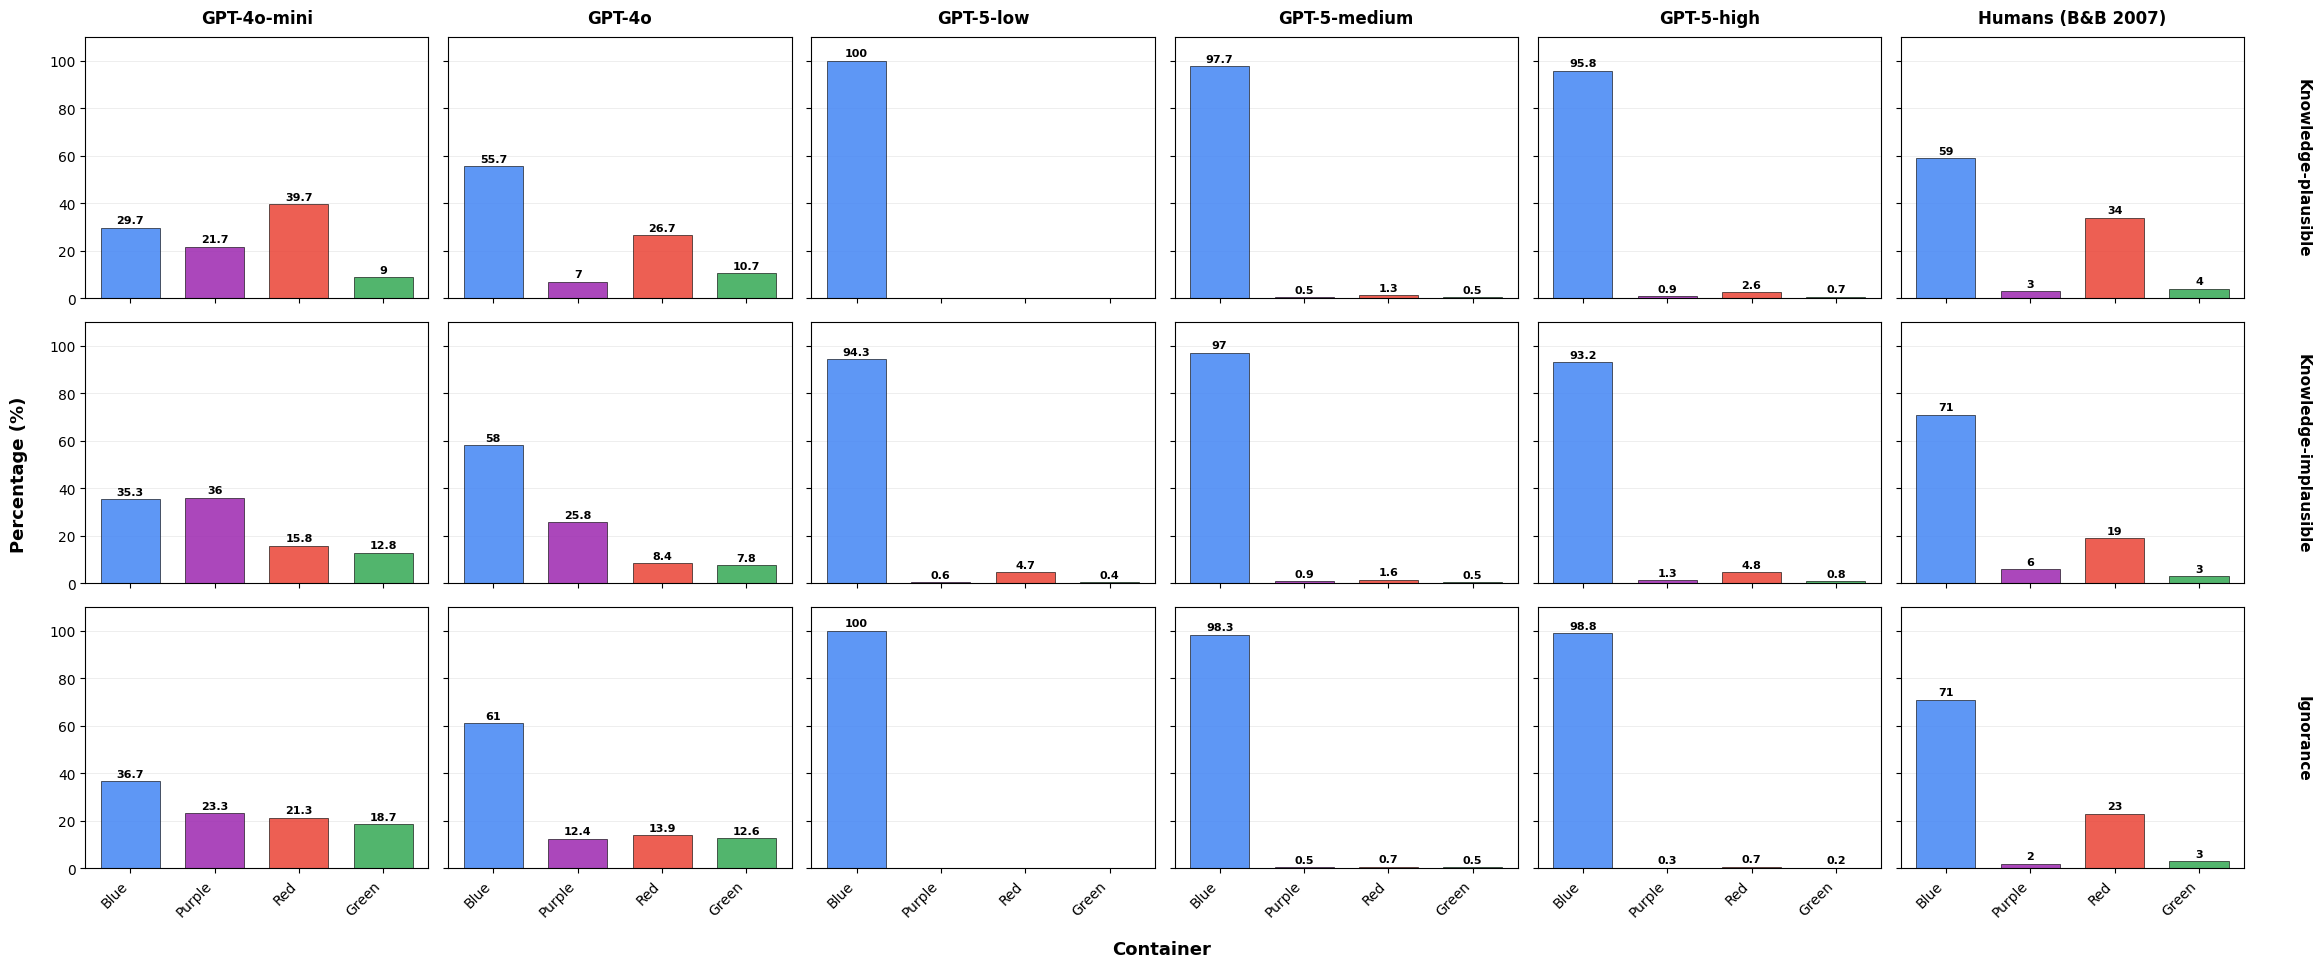

In [10]:
# Prepare data for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Use the model_order and model_display_names defined earlier
condition_order = ['Knowledge-plausible', 'Knowledge-implausible', 'Ignorance']
container_order = ['blue', 'purple', 'red', 'green']

# Define container colors
container_colors = {
    'blue': '#4285F4',
    'purple': '#9C27B0',
    'red': '#EA4335',
    'green': '#34A853'
}

# Create figure with 3 rows (conditions) × 6 columns (models)
fig, axes = plt.subplots(3, 6, figsize=(24, 10), sharex=True, sharey=True)

# Plot data
for i, condition in enumerate(condition_order):
    for j, model in enumerate(model_order):
        ax = axes[i, j]
        
        # Get data for this model and condition
        data = combined_data[(combined_data['model'] == model) & 
                            (combined_data['condition'] == condition)]
        
        # Prepare data for plotting
        x_pos = range(len(container_order))
        heights = [data[data['container'] == c]['mean'].values[0] if len(data[data['container'] == c]) > 0 else 0 
                  for c in container_order]
        colors = [container_colors[c] for c in container_order]
        
        # Create bars
        bars = ax.bar(x_pos, heights, color=colors, alpha=0.85, edgecolor='black', linewidth=0.5, width=0.7)
        
        # Add value labels on top of bars
        for bar, height in zip(bars, heights):
            if height > 0:  # Only show label if value > 0
                label = f'{height:.0f}' if height == int(height) else f'{height:.1f}'
                ax.text(bar.get_x() + bar.get_width()/2, height + 1, label,
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # Set labels and formatting
        ax.set_ylim(0, 110)  # Increased to make room for labels
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Blue', 'Purple', 'Red', 'Green'], rotation=45, ha='right', fontsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Add column headers (model names) on top row - use display names
        if i == 0:
            display_name = model_display_names.get(model, model)
            ax.set_title(display_name, fontsize=12, fontweight='bold', pad=10)
        
        # Add row labels (condition names) on right side
        if j == 5:
            ax.text(1.15, 0.5, condition, transform=ax.transAxes, 
                   fontsize=11, fontweight='bold', rotation=270, va='center')

# Set common labels
fig.text(0.5, 0.02, 'Container', ha='center', fontsize=13, fontweight='bold')
fig.text(0.02, 0.5, 'Percentage (%)', va='center', rotation='vertical', 
         fontsize=13, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.03, 0.04, 0.98, 0.98])

# Save
plt.savefig('analysis_plot_image.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved visualization to 'analysis_plot_image.png'")
plt.show()

✓ Saved visualization with std dev to 'analysis_plot_image_with_std.png'


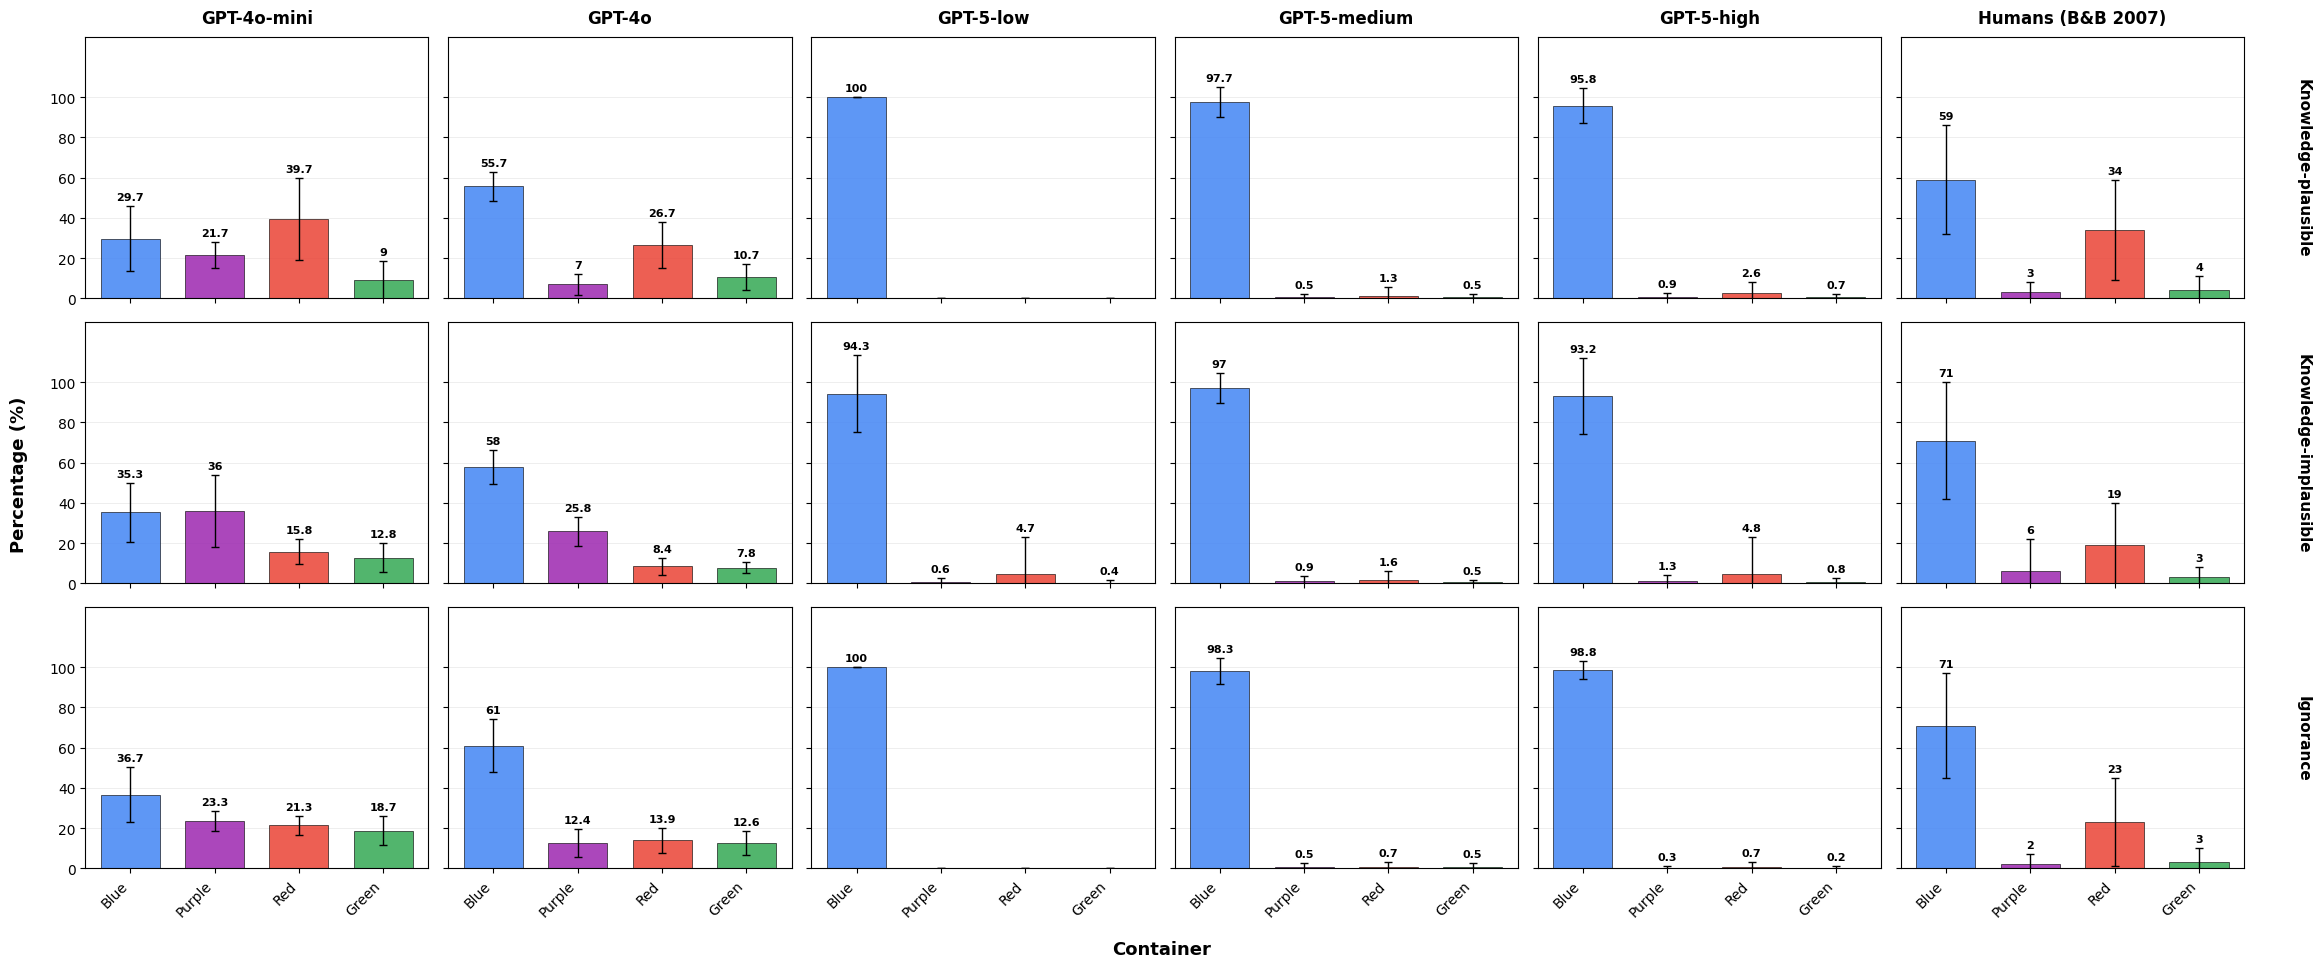

In [11]:
# Visualization with Standard Deviation Error Bars
import matplotlib.pyplot as plt

# Create figure with 3 rows (conditions) × 6 columns (models)
fig, axes = plt.subplots(3, 6, figsize=(24, 10), sharex=True, sharey=True)

# Plot data with error bars
for i, condition in enumerate(condition_order):
    for j, model in enumerate(model_order):
        ax = axes[i, j]
        
        # Get data for this model and condition
        data = combined_data[(combined_data['model'] == model) & 
                            (combined_data['condition'] == condition)]
        
        # Prepare data for plotting
        x_pos = range(len(container_order))
        heights = [data[data['container'] == c]['mean'].values[0] if len(data[data['container'] == c]) > 0 else 0 
                  for c in container_order]
        stds = [data[data['container'] == c]['std'].values[0] if len(data[data['container'] == c]) > 0 else 0 
               for c in container_order]
        # Handle NaN stds
        stds = [s if pd.notna(s) else 0 for s in stds]
        colors = [container_colors[c] for c in container_order]
        
        # Create bars with error bars
        bars = ax.bar(x_pos, heights, color=colors, alpha=0.85, edgecolor='black', linewidth=0.5, width=0.7,
                     yerr=stds, capsize=3, error_kw={'elinewidth': 1, 'capthick': 1})
        
        # Add value labels on top of bars (above error bars)
        for idx, (bar, height, std) in enumerate(zip(bars, heights, stds)):
            if height > 0:  # Only show label if value > 0
                label = f'{height:.0f}' if height == int(height) else f'{height:.1f}'
                label_y = height + std + 2 if std > 0 else height + 2
                ax.text(bar.get_x() + bar.get_width()/2, label_y, label,
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # Set labels and formatting
        ax.set_ylim(0, 130)  # Increased to make room for error bars and labels
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Blue', 'Purple', 'Red', 'Green'], rotation=45, ha='right', fontsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Add column headers (model names) on top row
        if i == 0:
            display_name = model_display_names.get(model, model)
            ax.set_title(display_name, fontsize=12, fontweight='bold', pad=10)
        
        # Add row labels (condition names) on right side
        if j == 5:
            ax.text(1.15, 0.5, condition, transform=ax.transAxes, 
                   fontsize=11, fontweight='bold', rotation=270, va='center')

# Set common labels
fig.text(0.5, 0.02, 'Container', ha='center', fontsize=13, fontweight='bold')
fig.text(0.02, 0.5, 'Percentage (%)', va='center', rotation='vertical', 
         fontsize=13, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.03, 0.04, 0.98, 0.98])

# Save
plt.savefig('analysis_plot_image_with_std.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization with std dev to 'analysis_plot_image_with_std.png'")
plt.show()

## Key Findings

### 1. Models Show NO Curse of Knowledge Bias

Unlike humans (Birch & Bloom 2007), all language models maintain near-perfect Theory of Mind reasoning:

**Human Performance:**
- Blue (belief): Ignorance 71% → K-Plausible 59% (-12%)
- Red (plausible): Ignorance 23% → K-Plausible 34% (+11%)
- **Clear curse-of-knowledge effect observed**

**Model Performance:**
- Blue: ~100% across all conditions
- Red: ~0% across all conditions
- **No bias detected**

### 2. Sensitivity Checks Passed

No significant differences found across:
- Name pairs (p > 0.05)
- Instruments (p > 0.05)
- Trials (p > 0.05)
- Color sets after mapping (p > 0.05)

### 3. Model Comparisons

- **Reasoning effort** (GPT-5 low/med/high): No difference in performance
- **Model families** (GPT-4 vs GPT-5): Minimal differences
- All models demonstrate robust false-belief reasoning

### 4. Interpretation

The absence of curse-of-knowledge bias in models suggests either:
1. Superior meta-cognitive abilities compared to humans
2. Lack of automatic egocentric processing that biases human responses
3. Exposure to similar tasks during training

Further research with more challenging Theory of Mind tasks is needed to distinguish between these interpretations.